In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors, model_selection, svm, neural_network, preprocessing, metrics
import random
random.seed(0)
seed = np.random.seed(0)
rng = np.random.RandomState(1)

## Load and split data

In [70]:
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=0) #split data with 70% for training and 30% for testing
print(f'Size of training data: {len(y_train)} observations')
print(f'size of test data: {len(y_test)}')

Size of training data: 75461 observations
size of test data: 32341


## Visualize Data

Label: 7


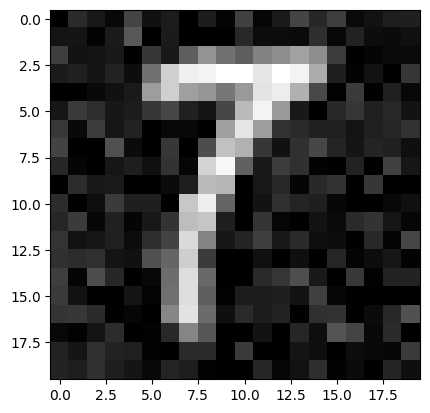

Label: 10


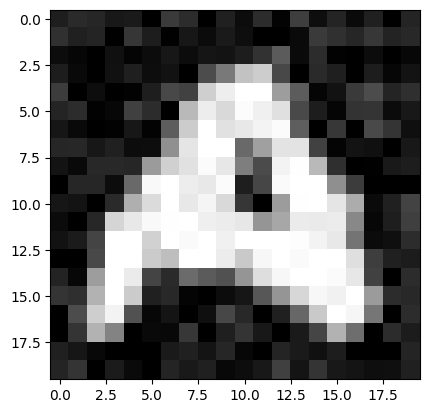

Label: 10


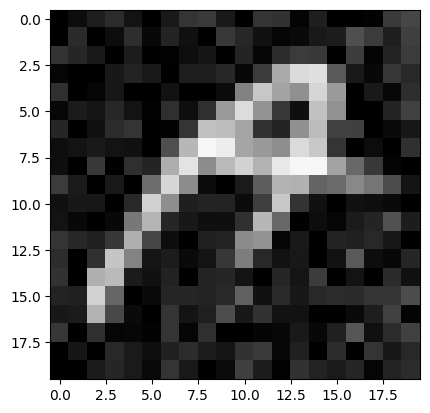

In [71]:
for i in range(0,3): #display a few of the images
    print(f'Label: {y_train[i]}')
    plt.imshow(X_train[i].reshape(20,20),vmin = 0, vmax = 255, cmap = "gray")
    plt.show()

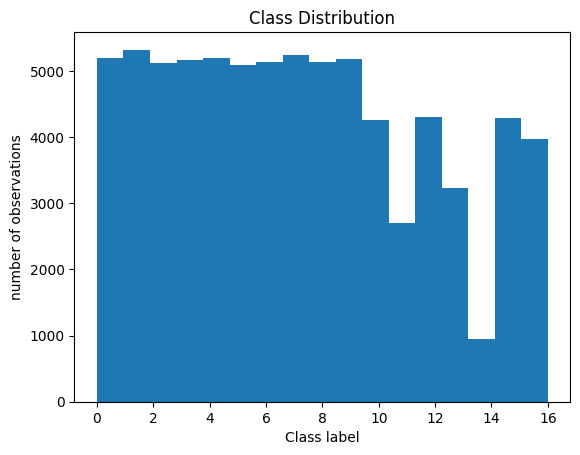

5201 occurances of class 0
5319 occurances of class 1
5123 occurances of class 2
5164 occurances of class 3
5201 occurances of class 4
5083 occurances of class 5
5139 occurances of class 6
5234 occurances of class 7
5127 occurances of class 8
5174 occurances of class 9
4254 occurances of class 10
2697 occurances of class 11
4299 occurances of class 12
3229 occurances of class 13
952 occurances of class 14
4289 occurances of class 15
3976 occurances of class 16


In [170]:
plt.hist(y_train,bins=17) #plot histogram of the occurances of each class in the training data
plt.title("Class Distribution")
plt.xlabel("Class label")
plt.ylabel("number of observations")
plt.show()
occurances = np.bincount(y_train)
for bin in range(0,len(occurances)):
    print(f'{occurances[bin]} occurances of class {bin}')

## Data Preprocessing
At this point it appears that the training data is moderately unbalanced because certain classes like class 14 (letter e) only have 952 occurances while most others are closer to or above 5000. I am choosing to downsample the data, so that all classes are distributed equally. There will still be over 10 times as many data points as there are predictors, so I believe there should be enough data to accurately train models. Also, this will greatly reduce the size of the training set, making it less computationaly expensive to train the models.

In [73]:
train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df["y"] = y_train
train_downsampled = pd.DataFrame()
class_size = occurances[np.argmin(occurances)]
for bin in range(0,len(occurances)): #for each class, only keep as many samples as there are present for the minority class
    class_data = train_df[train_df["y"] == bin]
    class_data_downsampled = class_data.sample(n = class_size, random_state= rng)
    train_downsampled = pd.concat([train_downsampled,class_data_downsampled],axis = 0)
y_train_downsampled = train_downsampled["y"].to_numpy()
X_train_downsampled = train_downsampled.drop(columns=["y"]).to_numpy()

Size of downsampled training data: 16184


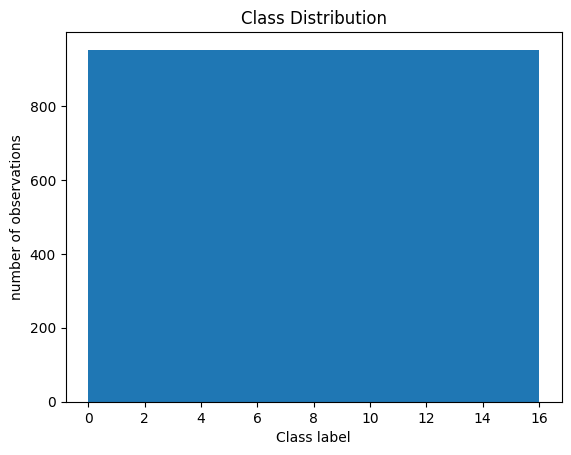

952 occurances of class 0
952 occurances of class 1
952 occurances of class 2
952 occurances of class 3
952 occurances of class 4
952 occurances of class 5
952 occurances of class 6
952 occurances of class 7
952 occurances of class 8
952 occurances of class 9
952 occurances of class 10
952 occurances of class 11
952 occurances of class 12
952 occurances of class 13
952 occurances of class 14
952 occurances of class 15
952 occurances of class 16


In [169]:
print(f'Size of downsampled training data: {len(y_train_downsampled)}') #data is now perfectly balanced while maintaining 40 times as many observations as there are variables
plt.hist(y_train_downsampled,bins=17)
plt.title("Class Distribution")
plt.xlabel("Class label")
plt.ylabel("number of observations")
plt.show()
occurances = np.bincount(y_train_downsampled)
for bin in range(0,len(occurances)):
    print(f'{occurances[bin]} occurances of class {bin}')

In [75]:
type(X_train_downsampled)

numpy.ndarray

Label: 14


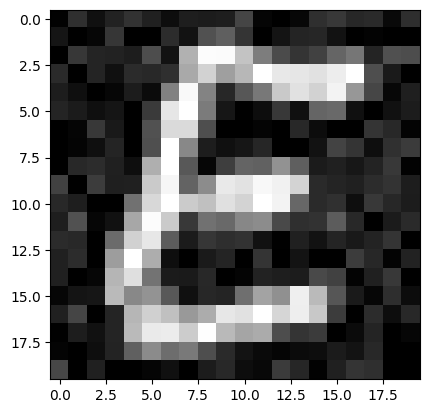

Label: 6


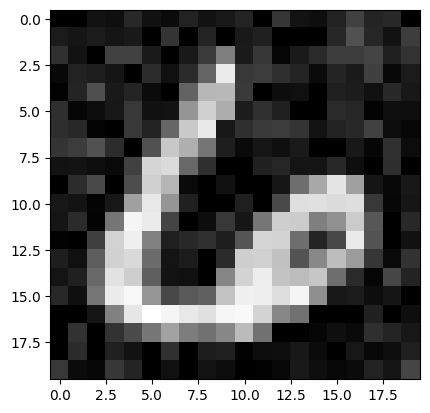

Label: 13


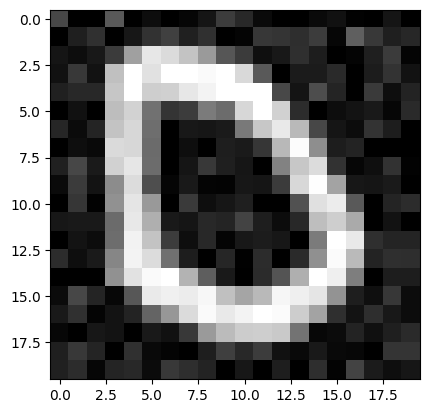

Label: 15


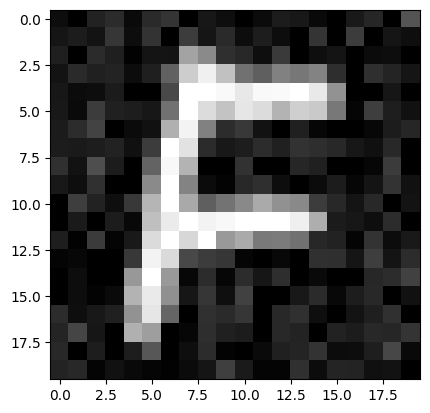

Label: 7


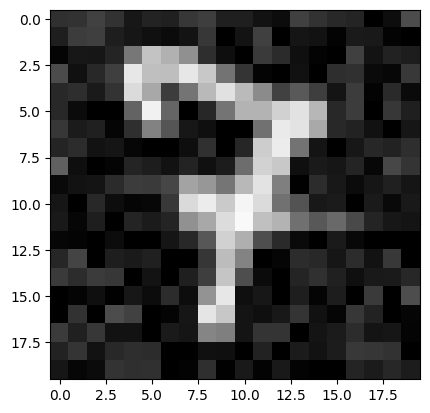

In [76]:
for i in range(0,5): #confirm that our labels still match with our data by displaying some random observations
    j = random.randint(0,len(y_train_downsampled))
    print(f'Label: {y_train_downsampled[j]}')
    plt.imshow(X_train_downsampled[j].reshape(20,20),vmin = 0, vmax = 255, cmap = "gray")
    plt.show()

Next preprocessing step will be to scale the data.

In [77]:
min_max_scaler = preprocessing.MinMaxScaler() #scale the data to values between 0 and 1
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_train_downsampled_scaled = min_max_scaler.transform(X_train_downsampled)
X_test_scaled = min_max_scaler.transform(X_test)
print(X_train_scaled[0])

[0.         0.344      0.2        0.07079646 0.52713178 0.14782609
 0.2295082  0.         0.21875    0.04385965 0.5078125  0.0483871
 0.22608696 0.57983193 0.34821429 0.48818898 0.07751938 0.14634146
 0.26086957 0.25619835 0.15267176 0.18584071 0.01744186 0.15384615
 0.45833333 0.         0.1173913  0.         0.         0.
 0.17596567 0.05529954 0.05454545 0.04149378 0.21800948 0.04
 0.15813953 0.07142857 0.07971014 0.13559322 0.52991453 0.11111111
 0.07843137 0.09411765 0.         0.21568627 0.09803922 0.36862745
 0.58039216 0.44705882 0.36862745 0.50588235 0.55294118 0.63529412
 0.55686275 0.23529412 0.         0.01960784 0.05405405 0.08333333
 0.19148936 0.19186047 0.08235294 0.13333333 0.05098039 0.44313725
 0.81176471 0.9372549  0.95294118 1.         1.         0.89803922
 1.         0.95294118 0.6745098  0.11764706 0.01176471 0.0745098
 0.         0.44354839 0.         0.         0.03529412 0.06666667
 0.10196078 0.61568627 0.81176471 0.62352941 0.58823529 0.46666667
 0.6       

## Model Training
Because the training data is completely balanced, using accuracy should be a good idea. Accuracy can be unfavorable for unbalanced data because classifiers tend to perform better at identifying classes which they have had more training for. Three potential classifiers: K-nearest neighbors, neural network, and support vector machine. Use grid search in order to tune hyperparameters.

In [78]:
# k nearest neighbors
# use cross validation to determine optimal value of k
knn = neighbors.KNeighborsClassifier()
neighbors_list = list(range(1,50,2))
parameters = {'n_neighbors':neighbors_list}
knn_clf = model_selection.GridSearchCV(knn,parameters,scoring="accuracy")
knn_clf.fit(X_train_downsampled_scaled,y_train_downsampled)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             scoring='accuracy')

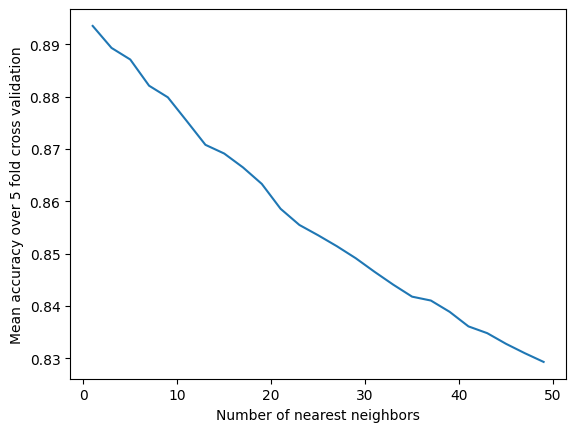

Best value of k is 1 with mean accuracy: 0.8935367790454392


In [79]:
plt.plot(neighbors_list,knn_clf.cv_results_["mean_test_score"])#plot results and display best value of k
plt.xlabel("Number of nearest neighbors")
plt.ylabel("Mean accuracy over 5 fold cross validation")
plt.show()
print(f'Best value of k is {neighbors_list[knn_clf.best_index_]} with mean accuracy: {knn_clf.cv_results_["mean_test_score"][knn_clf.best_index_]}')

In [80]:
#create knn model with optimal value of k to be used in model evaluation
knn_model = neighbors.KNeighborsClassifier(n_neighbors = neighbors_list[knn_clf.best_index_])

In [81]:
#neural network
#create a baseline model with default parameters to compare the performance of the tuned models against
#use grid search to tune hyperparameters using cross validation
mlp_baseline = neural_network.MLPClassifier(random_state=rng)
parameters = {'hidden_layer_sizes':[(200,), (300,), (200, 100), (100, 50)],'learning_rate_init':[0.1,0.01,0.001]} #hidden layer sizes chosen based on size of input and output layer
mlp_clf = model_selection.GridSearchCV(mlp_baseline, parameters, scoring = "accuracy")
mlp_clf.fit(X_train_downsampled_scaled,y_train_downsampled)
mlp_baseline_accuracy = np.mean(model_selection.cross_val_score(mlp_baseline,X_train_downsampled_scaled,y_train_downsampled, cv = 5 ,scoring = "accuracy"))

In [82]:
print(f'Best model has mean accuracy {mlp_clf.cv_results_["mean_test_score"][mlp_clf.best_index_]} with parameters {mlp_clf.best_params_}')
print(f'Baseline model accuracy (default hyperparameter settings) is {mlp_baseline_accuracy}.')
mlp_model = neural_network.MLPClassifier(hidden_layer_sizes=mlp_clf.best_params_['hidden_layer_sizes'],learning_rate_init=mlp_clf.best_params_['learning_rate_init'])

Best model has mean accuracy 0.9233811350756262 with parameters {'hidden_layer_sizes': (300,), 'learning_rate_init': 0.01}
Baseline model accuracy (default hyperparameter settings) is 0.9016306931634496.


In [83]:
#svm
#again use grid search to evaluate models with different hyperparameters
#use baseline model with default parameters to compare the tuned model to
svm_baseline = svm.SVC(random_state=rng)
svm_parameters = {'C':[1,10,100],'gamma':["scale",0.001,0.0001]} #I include default 'scale' value for gamma because I found worse results compared to the baseline without it
svm_clf = model_selection.GridSearchCV(svm_baseline,svm_parameters,scoring = "accuracy")
svm_clf.fit(X_train_downsampled_scaled,y_train_downsampled)
svm_baseline_accuracy = np.mean(model_selection.cross_val_score(svm_baseline, X_train_downsampled_scaled, y_train_downsampled, cv = 5, scoring = "accuracy"))


In [84]:
print(f'Best model has mean accuracy {svm_clf.cv_results_["mean_test_score"][svm_clf.best_index_]} with parameters {svm_clf.best_params_}')
print(f'Baseline model accuracy (default hyperparameter settings) is {np.mean(svm_baseline_accuracy)}.')
svm_model = svm.SVC(C = svm_clf.best_params_['C'],gamma=svm_clf.best_params_['gamma'])

Best model has mean accuracy 0.9401877549181226 with parameters {'C': 10, 'gamma': 'scale'}
Baseline model accuracy (default hyperparameter settings) is 0.9317223634482783.


## Model Selection
Now that we have three different classifiers with tuned hyperparameters, we can now use cross validation on our training data in order to evaluate the classifiers and select the best one. I will use the entire training data set now because there are only 3 different models that need to be trained and evaluated, so computation time is less of a concern. I will also continue to look at accuracy in order to maintain consistency and also because the data is only moderately unbalanced, so accuracy should still be a good measure of performance.

In [85]:
classifier_dict = {"K-nearest neighbors":knn_model, "Neural Network" : mlp_model, "Support Vector Machine": svm_model} #train three models on training set and calculate mean cross validation accuracy
cv_accuracy_list = []
for classifier in classifier_dict:
    cv_accuracy = np.mean(model_selection.cross_val_score(classifier_dict[classifier],X_train_scaled,y_train,cv = 5, scoring = "accuracy"))
    cv_accuracy_list.append(cv_accuracy)
    print(f'Classifier {classifier} had cross validation accuracy: {cv_accuracy}')


Classifier K-nearest neighbors had cross validation accuracy: 0.9391738699522278
Classifier Neural Network had cross validation accuracy: 0.946528678303714
Classifier Support Vector Machine had cross validation accuracy: 0.9652933067740852


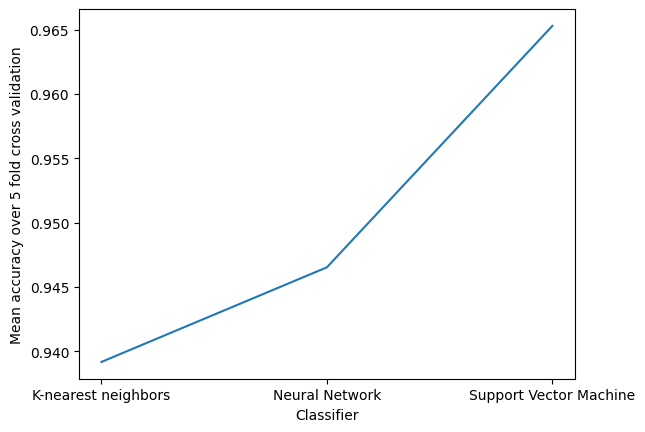

In [88]:
plt.plot(cv_accuracy_list)
classifier_names = list(classifier_dict.keys())
plt.xlabel("Classifier")
plt.ylabel("Mean accuracy over 5 fold cross validation")
plt.xticks([0,1,2],classifier_names)
model_chosen = classifier_dict[classifier_names[np.argmax(cv_accuracy_list)]] #automatically select model with highest accuracy

## Model Evaluation
We now evaluate the chosen model on the test data that was set aside at the beginning. In order to evaluate the model, I will look at different classification metrics such as precision, accuracy, recall, and f1 score. I will also display the confusion matrix to see how the model performed on specific classes. We can compare this to the original class distribution graph in the training set to see if this is because of imbalance in the data set. It could also be useful to display some of the images that were incorrectly classified.

Classification report for SVC(C=10):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2191
           1       0.99      0.98      0.99      2333
           2       0.98      0.98      0.98      2254
           3       0.97      0.98      0.98      2222
           4       0.98      0.97      0.97      2225
           5       0.97      0.98      0.97      2123
           6       0.98      0.99      0.99      2239
           7       0.98      0.98      0.98      2215
           8       0.94      0.96      0.95      2158
           9       0.97      0.97      0.97      2202
          10       0.97      0.96      0.97      1782
          11       0.92      0.92      0.92      1190
          12       0.98      0.97      0.97      1920
          13       0.93      0.92      0.93      1353
          14       0.89      0.94      0.91       364
          15       0.95      0.96      0.96      1867
          16       1.00      1.00      1.00 

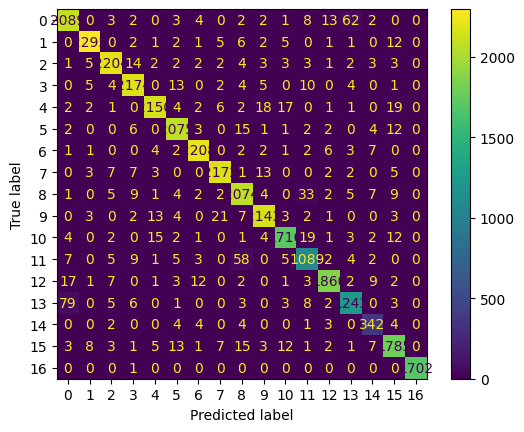

In [87]:
model_chosen.fit(X_train_scaled,y_train)
model_predictions = model_chosen.predict(X_test_scaled)#calculate predictions on unseen test data
print(f'Classification report for {model_chosen}:\n{metrics.classification_report(model_predictions,y_test)}')#display metrics to evaluate classification performance
print(f'Confusion matrix:\n{metrics.ConfusionMatrixDisplay.from_predictions(model_predictions,y_test)}')

We can see that the classifier performed very well overall, with a test accuracy of 97%. The individual F1 scores are a little less impressive however, with certain classes like 14 having a score of .91 due to the fairly low precision of 89% for that class. Looking at the confusion matrix provides further insight into this. The numbers of values that were misclassified as class 14 do not look particularly high, but given the relatively low number of observations for class 14 overall, these misclassifications were significant. The label that the model performed best on was label 16 which makes sense. Label 16 is the blank label which was much easier for the model to differentiate from the other classes.

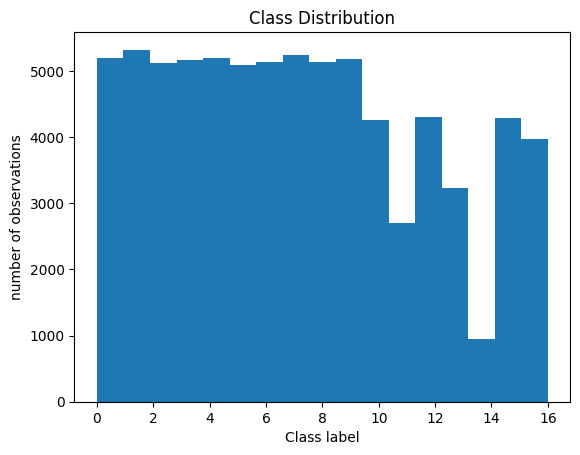

In [168]:
plt.hist(y_train,bins=17)
plt.title("Class Distribution")
plt.xlabel("Class label")
plt.ylabel("number of observations")
plt.show()

We can see that the model had the lowest F1 scores for classes 11 and 14. When we compare this to the initial class distribution in the training data, this looks like it can be explained by the relatively low number of observations for classes 11 and especially 14.

I now want to try and use dimensionality reduction to try and create a good visualization of the clusters of data, and to see where the classifier went wrong.

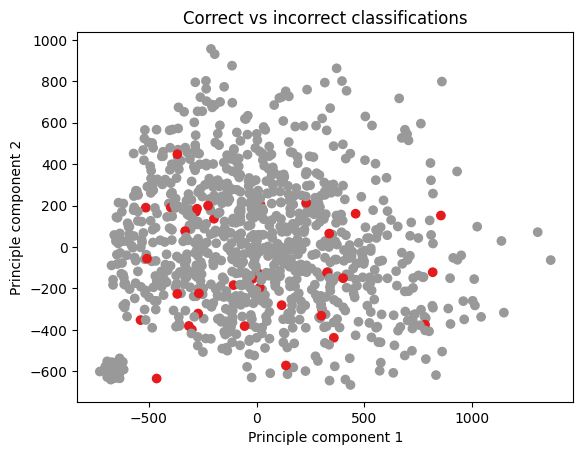

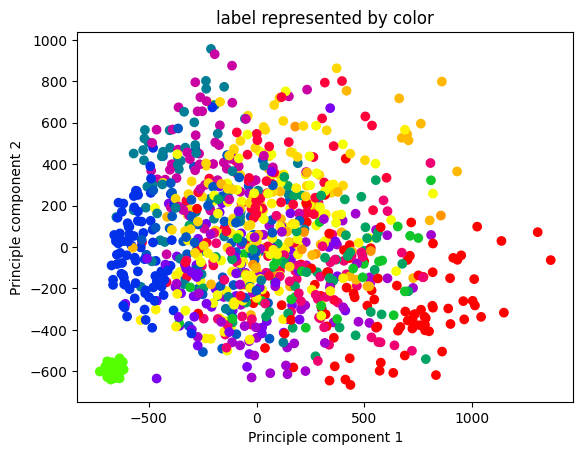

In [131]:
from sklearn.decomposition import PCA
visualization_df = pd.DataFrame(X_test)
visualization_df['y'] = y_test
visualization_df['predictions'] = model_predictions
visualization_df = visualization_df.sample(1000) #take random sample of 500 so visualization isn't too crowded
pca = PCA(n_components=2) #want first 2 principle components
pca_results = pca.fit_transform(visualization_df.iloc[: , :400]) #calculate principle components of data subset
plt.scatter(pca_results[:,0],pca_results[:,1],c=(visualization_df['y'] == visualization_df['predictions']),cmap='Set1')
plt.title("Correct vs incorrect classifications")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")
plt.show()
plt.scatter(pca_results[:,0],pca_results[:,1],c=visualization_df['y'],cmap='prism')
plt.title("label represented by color")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")
plt.show()

I used PCA to reduce the data to two dimensions in the hope that obvious clusters would appear. Some very obvious clusters appeared like the one in the bottom left corner. This cluster represents label 16 which is the blank label. This plot gives a good visualization of how this label is much easier to differentiate from the others. My goal was to have different markers to show the predicted value and different colors show the actual value. I had a hard time finding a way to do this however.

Lastly, lets look at some of the misclassified images:

Correct label: 15
Predicted label: 7


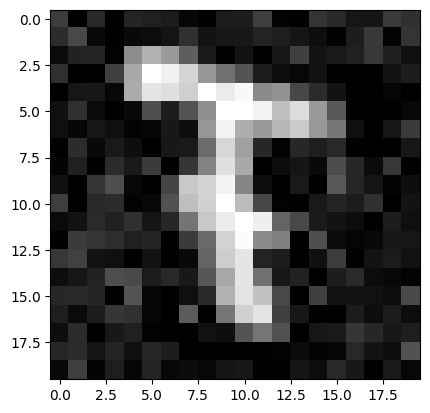

Correct label: 8
Predicted label: 5


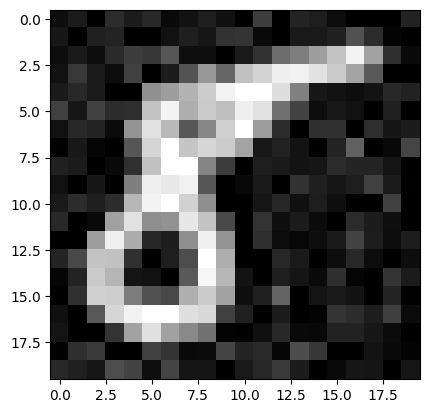

Correct label: 5
Predicted label: 8


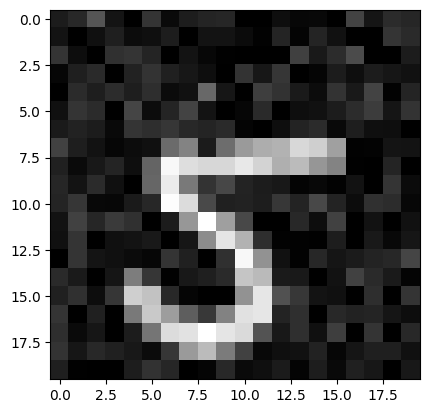

Correct label: 13
Predicted label: 0


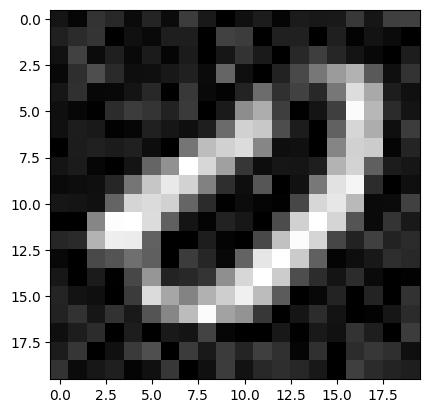

Correct label: 4
Predicted label: 10


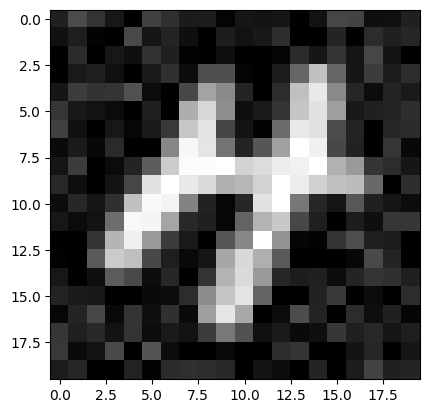

Correct label: 8
Predicted label: 11


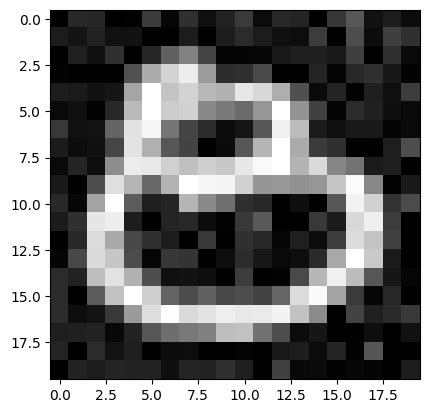

Correct label: 12
Predicted label: 6


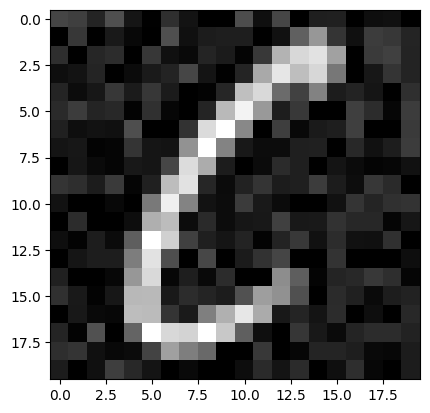

Correct label: 0
Predicted label: 12


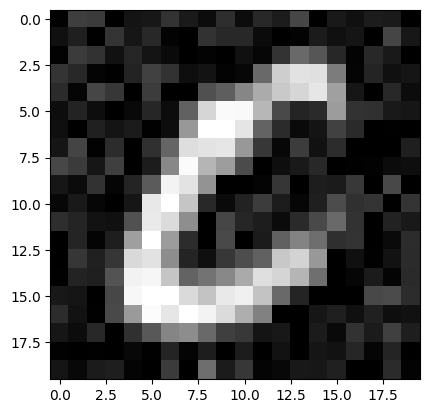

Correct label: 0
Predicted label: 13


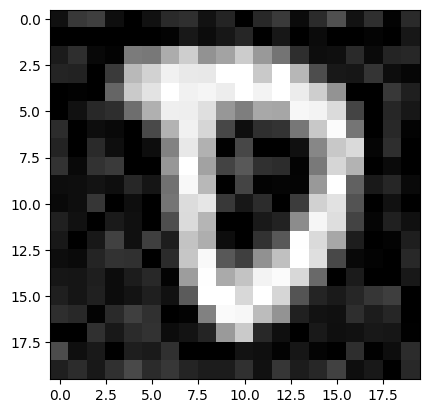

Correct label: 8
Predicted label: 11


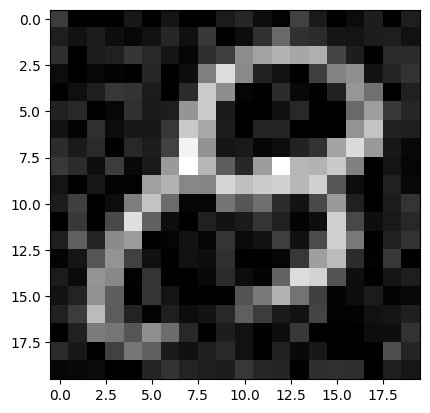

In [164]:
misclassified = pd.DataFrame(X_test)
misclassified['y'] = y_test
misclassified['predicted'] = model_predictions
misclassified = misclassified[misclassified['y'] != misclassified['predicted']] #create dataframe of misclassified points to randomly sample from and then display
for _ in range(0,10):
    image_misclf = misclassified.sample()
    pixels = image_misclf.iloc[:,:400].to_numpy()
    correct_label = image_misclf['y'].iloc[0]
    predicted_label = image_misclf['predicted'].iloc[0]
    print(f'Correct label: {correct_label}\nPredicted label: {predicted_label}')
    plt.imshow(pixels.reshape(20,20),vmin = 0, vmax = 255, cmap = "gray")
    plt.show()

Looking at some of the misclassified images, I am not surprised that the model struggled to classify them because I would have probably misclassified some of these too.